# **Student Performance in Exams**
#### The goal of this project is to find the feature(s) of the dataset that best correlate to students getting high grades and build a classification model with these features.  

**Dataset feature(s):**

1. gender: sex of students
1. race/ethnicity: ethnicity of students
1. parental level of education: parents' final education
1. lunch: having lunch before the test (normal or abnormal)
1. test preparation course: complete or not complete before the test
1. math score: score in math exam 
1. reading score: score in reading exam 
1. writing score: score in writing exam 

**Hypothesis:** The features likely to play a major role in student test scores are the other test scores, when predicting one test score there is a greater likelihood that students will have other high scores.

The **[Students Performance in Exams](https://www.kaggle.com/spscientist/students-performance-in-exams)** dataset was chosen because:
* It was reasonably sized at 1000 samples 
* It had no crippling imbalances in the data 
* It was a complete dataset with no missing entries

## How to run notebook

To run this notebook create the following folders in the notebook location:

* Datasets
* Feature_Selection/RF
* Feature_Selection/SVM
* Figures/RF
* Figures/SVM
* Reports/RF
* Reports/SVM

Download the dataset from the link in the notebook and place in the datasets folder.


In [1]:
# Libraries to be imported
import os
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, \
    precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from IPython.display import Image, display

### **Data Preparation and Analysis Summary** 
The Pandas Library will be used for analysis because it offers a wide array of functions to prepare and analyse data. 
* Spaces and special characters in column names could complicate certain coding tasks; therefore, these were removed
* String values were encoded as they are not valid inputs to a machine learning algorithm 
* Gender features were balanced whereas the remaining features were unbalanced to some degree
* Math, reading and writing scores have too many unique values which make classification more difficult so they were placed into balanced groups using the summary stats from the describe() function 
    * Math, reading and writing scores follow the expected Gaussian distribution 
* No missing values in the dataset    

In [2]:
# Visualise dataset
DATASET = "Datasets/StudentsPerformance.csv"
data = pd.read_csv(DATASET) # Get dataset from CSV file 
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
# Rename columns to be easier to work with 
data.rename(columns={"race/ethnicity":"ethnicity","parental level of education":"parent_education"
                    ,"math score":"math_score","reading score":"reading_score","writing score":"writing_score",
                    "test preparation course":"prep_course"},inplace=True)
data.head()

,gender,ethnicity,parent_education,lunch,prep_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
def get_features(df):
    """
    Gets the features in a dataframe
    :param df (dataframe): dataframe to get features from
    :return features (list): return a list of the features
    """
    # Create a features list
    features = []

    # Get the shape of the dataset
    dfshape = df.shape

    # Append dataset column names to the features list
    for i in range(0, dfshape[1]): 
        features.append(df.columns[i])
    
    return features

In [5]:
# Get features for the current dataset 
features = get_features(data)

In [6]:
# Displays the names of columns, the data types they contain, 
# and whether they have any missing values.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            1000 non-null   object
 1   ethnicity         1000 non-null   object
 2   parent_education  1000 non-null   object
 3   lunch             1000 non-null   object
 4   prep_course       1000 non-null   object
 5   math_score        1000 non-null   int64 
 6   reading_score     1000 non-null   int64 
 7   writing_score     1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [7]:
# Get the number of unique values in each of the columns 
data.nunique()

gender               2
ethnicity            5
parent_education     6
lunch                2
prep_course          2
math_score          81
reading_score       72
writing_score       77
dtype: int64

In [8]:
# Returns some summary stats such as count,
# mean, std, min, max and data types
print(data.describe(), "\n")
data.describe(include=object) # Strings not included by default


       math_score  reading_score  writing_score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000 



,gender,ethnicity,parent_education,lunch,prep_course
count,1000,1000,1000,1000,1000
unique,2,5,6,2,2
top,female,group C,some college,standard,none
freq,518,319,226,645,642


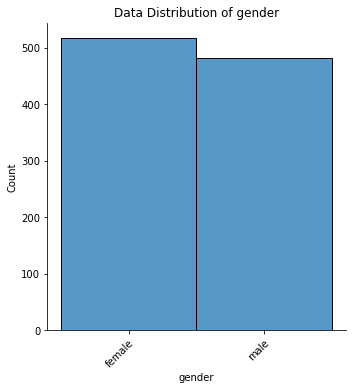

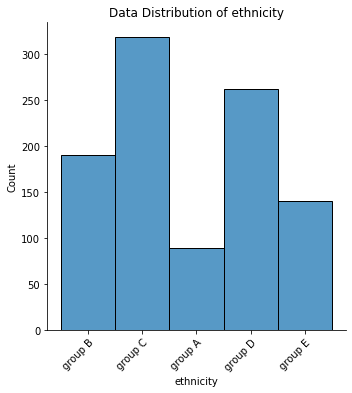

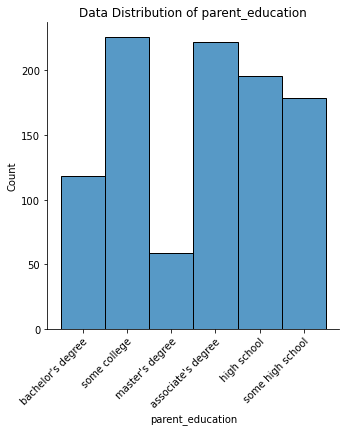

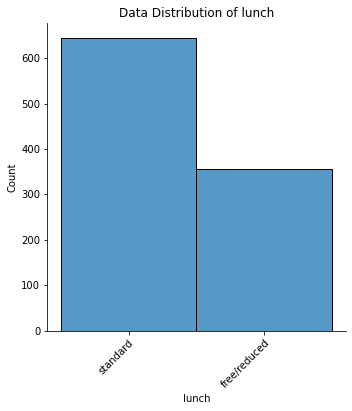

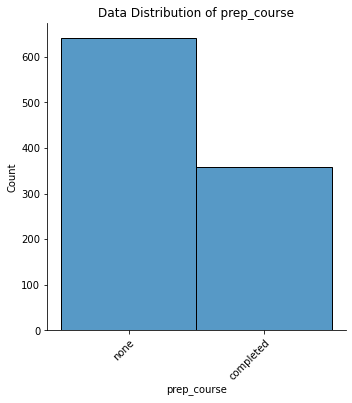

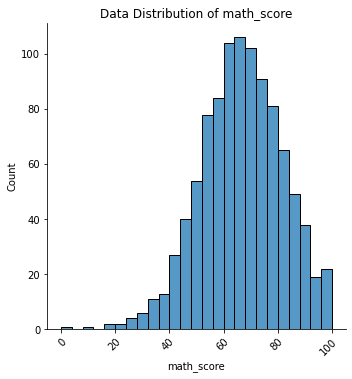

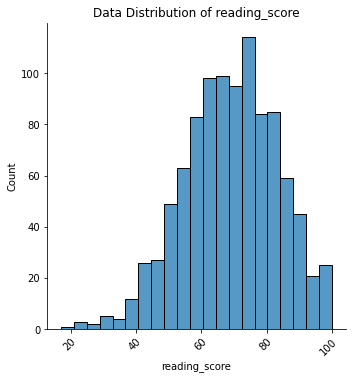

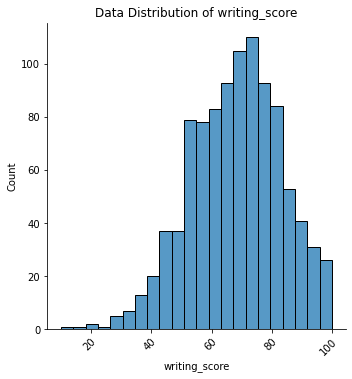

In [9]:
# Create graphs to visualise the balance of the dataset
for feature in features:
    print(sns.displot(data[feature]))
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.title("Data Distribution of {}".format(feature))
 

Seaborn displot function autamatically puts score data into groups but they are still unbalanced 

In [10]:
# Visualise exact values to help in grouping data 
def print_full_col(col_name):
    """
    Prints the full index sorted column of the number a value appears in the column
    :param col_name (str): Name of the column to print
    """
    sorted_data = data[col_name].value_counts().sort_index(ascending=True)
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3,
                           ):
        print(sorted_data)

In [11]:
print_full_col("math_score")

0       1
8       1
18      1
19      1
22      1
23      1
24      1
26      1
27      2
28      1
29      3
30      2
32      3
33      1
34      2
35      5
36      2
37      4
38      3
39      4
40     10
41      6
42      6
43      5
44      9
45      9
46     11
47     11
48     11
49     17
50     15
51     11
52     18
53     24
54     18
55     18
56      9
57     18
58     25
59     32
60     16
61     27
62     35
63     26
64     20
65     36
66     24
67     26
68     26
69     32
70     18
71     26
72     18
73     27
74     25
75     21
76     21
77     24
78     14
79     22
80     17
81     22
82     18
83      8
84     11
85     14
86      8
87     16
88     15
89      6
90      8
91      9
92      6
93      4
94      7
95      2
96      3
97      6
98      3
99      3
100     7
Name: math_score, dtype: int64


# **Grouping scores**

The dataset had too many unique values for the test scores which would result in poor performance. To resolve this issue four different groupings were tested and their performance evaluated.

### **Group selection methods**

In the previous section the pandas function data.describe() was used to get the mean of the different scores, these means were 66, 69 and 68 for maths, reading and writing respectively. These values were used to get an even split of data in the smaller groups, the groups were consistent across all score ranges for comparison and code complexity reduction.

### **Ten Classes**

* This grouping was used to see if it was possible to maintain good separation of the individual test scores 
* The minimum group was around 40 whilst the highest was around 140 for each of the scores. Although not perfectly balanced this compromise was made so the grouping would make sense

### **Four Classes**

* This grouping followed the same principle as the ten classes but with fewer classes to get a better accuracy  
* The minimum for a group was around 200 data points whereas the maximum was around 300 making for a relatively more balanced spread of data than Ten classes

### **Three Classes**

* This grouping was to check if it was possible to get a separation between the higher-performing students

### **Two Classes**

* This grouping was used to produce the highest accuracy results 
* The minimum for a group was around 450 meaning that each class had a balanced distribution

### **Selecting Different Groups**

To reduce code complexity a manual method for testing all the groups was implemented. To test through all the different groups uncomment the desired "names" and "bins" leaving the rest of the groups commented then change the "GROUP_PATH" variable keeping the same naming format as this is used to save graphs and figures for those tests.


In [12]:
# Pandas cut() function is used to separate the array elements into different bins.
# The cut function is mainly used to perform statistical analysis on scalar data. 
# The bins are the diffenret groups to split the data into 

# Mean of the mean scores ~ 67 (66+68+69)/3
# No need to complicate results by using different values when they are so close

# Two Classes
bins = [-1, 67, 100]  
names = ["=<67", ">=68"]

# Three classes
#bins = [-1, 66, 77, 100]  # clost to mean values
#names = ["=<66", "67-77", ">=78"]

# Four classes
#bins = [-1, 57, 66, 77, 100]  # clost to mean values
#names = ["=<57","58-66", "67-77", ">=78"]

# Ten Classes
#bins = [-1, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100]  # -1 required so 0 values are included
#names = ["=<45","46-50", "51-55", "56-60", "61-65", "66-70", "71-75","76-80", "81-85", "86-90", "91-100"]

score_cols = ["math_score", "reading_score", "writing_score"]
ranged_score_cols = ["math_score_range", "reading_score_range", "writing_score_range"]

# Name of classes to add to the path when saving
GROUP_PATH = "Two_classes_" 

# This loop is here so the cell can be run multiple times without throwing 
# an error due to the columns being already deleted
for col, new_col in zip(score_cols, ranged_score_cols):
    if col in data.columns:
        data[new_col] = pd.cut(data[col], bins, labels=names)


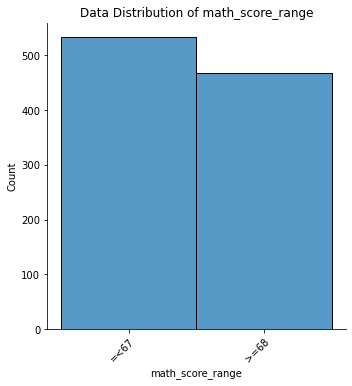

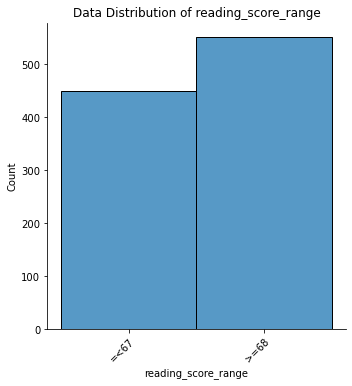

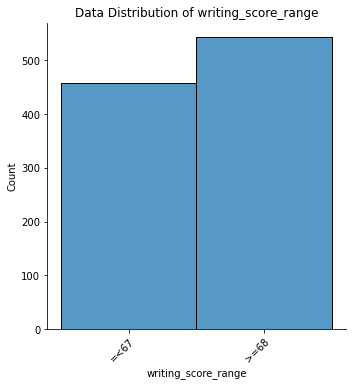

In [13]:
# Plot score range 
for col in ranged_score_cols:
    sns.displot(data[col])
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.title("Data Distribution of {}".format(col))

# **Model selection and training**

The models that will be tested are a Support Vector Machine and Random Forest 

### **SVM**
* Multiclass classfication 
* Good General-purpose algorithm 
* Better performance when data has clear margins 

### **RF**
* Built in feature impontance 
* Multiclass classfication 
* Decision trees are simpler to visualise 


In [14]:
# This loop is here so the cell can be run multiple times without throwing 
# an error due to the columns being already deleted
for col in score_cols:
    if col in data.columns:
        data = data.drop(columns=col)

features = get_features(data)
# Encode features 
for i in range (0, len(features)):
    if type(data[features[i]][1]) == str:
        le = LabelEncoder()
        data[features[i]] = le.fit_transform(data[features[i]])

In [15]:
def get_file_names(path):
    """
    Returns the file names of the relative path given, the relative path is from the notebook file location
    :param path (str): relative path to get files e.g. "Test/Path"
    """
    dir_path = os.getcwd()
    f_names = os.listdir(dir_path + "/" + path)
    if ".ipynb_checkpoints" in f_names:
        f_names.remove(".ipynb_checkpoints") # First element is an unwanted file
    return f_names
    

In [16]:
# This function is used to save classfication reports from multiple runs 
def save_report_csv(y_true, y_pred, targets, path):
    """
    Save classification reports as csv file 
    :param y_true (Any): The true values 
    :param y_pred (Any): The predicted values 
    :param targets (Any): The targets 
    :param path (str): Path to save the report     
    """
    report = classification_report(y_true, y_pred, zero_division=0, target_names=targets, output_dict=True)

    # Get the same format as unmodified report
    report.update({"accuracy": {"precision": None, "recall": None, "f1-score": report["accuracy"],
                                "support": report['macro avg']['support']}})
    df = pd.DataFrame(report).transpose()
    df.to_csv(path)

# **Random Forest Implmentation**

This code creates feature importance, classification report, confusion matrix and tree plot for the best estimator. 

GridSearchCV() is a function that can be used to find the best estimator when given a parameter grid. Documentation was used to get the hyperparameters for the random forest. The below parameters were tested to see the impact on the model, with very little change for computation of over 20 minutes, these parameters have little impact on the optimisation and can be left at default values. The best estimator is decided by the one that gives the highest accuracy in predictions.
 
* "criterion":["gini", "entropy"],
* "min_samples_split": [10, 50, 100],
* "max_features": ["auto", "sqrt", "log2"],
* "oob_score": [True, False]}


In [17]:
# Defining parameter range
param_grid_rf = {"max_depth": [2, 8, 16],
                 "max_leaf_nodes": [25, 50, 75, 100],
                 "n_jobs": [-1],
                 "n_estimators": [64, 128, 256, 512, 1024]}

# The best estimator for each score is saved as it's overwritten in multiple runs 
estimators_rf = {"math_score_range": "" ,
                 "reading_score_range": "",
                 "writing_score_range": ""}

# This loop is for each of the different scores 
# ranged_score_cols is defined in grouping scores section, placed here for reference 
# ranged_score_cols = ["math_score_range", "reading_score_range", "writing_score_range"]
for score_type in ranged_score_cols:
    # Select training and targets data 
    data_rf = data.copy() # Don't change encoded dataset
    y_rf = data_rf[score_type] # Lowercase y is standard name for one-dimensional targets 

    # Remove target from training data
    data_rf = data_rf.drop(columns=[score_type])
    X_rf = data_rf # Capital X is standard name for multi-dimensional array inputs 
    
    # Scale dataset
    std_scaler = StandardScaler()
    X_rf_scaled = std_scaler.fit_transform(X_rf)
    
    # Cross validation by splitting training data 
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
        X_rf_scaled, y_rf, random_state=100)

    # Use param_grid defined earlier 
    grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, refit = True, \
                           verbose = 1, return_train_score=True)

    # Fitting the model for grid search
    grid_rf.fit(X_train_rf, y_train_rf)

    # Print best parameter after tuning
    print("\nBest Parameters {}: {} \n".format(score_type, grid_rf.best_params_))

    # Print how model looks after hyper-parameter tuning
    print("\nBest Estimator {}: {} \n".format(score_type, grid_rf.best_estimator_))
    
    # Save best estimator 
    estimators_rf[score_type] = grid_rf.best_estimator_
     
    # GridSearchCV does not implement feature importance, need to use an estimator
    rf_clf = grid_rf.best_estimator_
    rf_clf.fit(X_train_rf, y_train_rf)
    y_pred_rf = rf_clf.predict(X_test_rf)
    print("\nRandom Forest Accuracy {}: {} ".format(score_type, accuracy_score(y_test_rf, y_pred_rf)))
          
    # Get feature relevance
    estimator=rf_clf.estimators_[3]

    important_features_names = []
    important_features_scores = []

    new_features = features.copy() 
    new_features.remove(score_type)

    for name, score in zip(new_features, rf_clf.feature_importances_):
        important_features_names.append(name)
        important_features_scores.append(score) 
          
    # Plot feature importance 
    plt.bar(important_features_names, important_features_scores)
    plt.ylabel("Percentage")
    plt.title("Random Forest Feature Importance " + GROUP_PATH + score_type)
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.grid(axis = 'y')
    plt.tight_layout()
    # Cuts labels if not pdf extention 
    plt.savefig("Figures/RF/RF_Feature_Importance_" + GROUP_PATH + score_type + ".jpeg", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Classifcation report
    print("Classifcation report " + GROUP_PATH + score_type)
    report_rf = classification_report(y_test_rf, y_pred_rf, zero_division=0, target_names=names)
    save_report_csv(y_test_rf, y_pred_rf, names, "Reports/RF/RF_" + GROUP_PATH + score_type + ".csv")
    print(report_rf)
          
    # Create confusion matrix 
    cm_rf = confusion_matrix(y_test_rf, y_pred_rf)

    # plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=names)
    disp.plot(xticks_rotation=45)
    plt.title("Confusion Matrix " + GROUP_PATH + score_type)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
    plt.savefig("Figures/RF/RF_Confusion_Matrix_" + GROUP_PATH + score_type + ".jpeg", dpi=300, bbox_inches='tight')
    plt.show()
          
    # Plot tree
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=1000)
    tree.plot_tree(estimator, filled = True, feature_names = features);
    plt.show()

Fitting 5 folds for each of 60 candidates, totalling 300 fits


# **Comparing Different Groups Sizes RF**

The purpose of this code is to get all the saved reports and load the results for comparison.

### **Ten Classes**
* Low precision and recall with some groups getting 0 
* Mixed results between classes
* Around 40% accuracy when predicting across all scores
* 10 classes are too many to produce reliable results of any kind 

### **Four Classes**
* Reading and writing produced usable classifiers with around 70% accuracy 
* Math scores classifier had poor recall and precision for identifying lower scores
* Trend is that F1 scores are all significantly lower for identifying lower scores  
* Overall okay classifiers but held back by performance at lower scores 

### **Three Classes** 
* Even combined the lower scores still show noticeable performance losses compared to the higher scores
* Overall accuracy has improved to 80% 
* The three classes model achieves the goal of differentiating between the higher groups but is held back by the performance in the lower scores group

### **Two Classes** 
* Best performing model confirming the trend that the reading and writing model performs better than the maths model 
* Around 90% accuracy for reading and writing but only 80% for math model 
* Resolves the issue of performance on low scores by having f1 scores similar to accuracy which was not the case for other models

### **Feature importance**
The feature importance showed a consistent trend, the maths scores were more impacted by gender, ethnicity, parent education, lunch, and prep course across all the different groups than the reading and writing scores. This effect was so pronounced that in all groups except two classes the values rarely exceeded 5% importance. The most impactful features on math scores were still reading and writing but these values only had peeks of 30% compared to the 60% peaks of how reading and writing were important to each other. The feature importance showed that those with a good reading score are likely to get a good writing score and those with a good writing score are likely to get a good reading score. The student’s understanding of math had a marginal impact on their reading and writing. 




In [ ]:
report_path_rf = "Reports/RF/"
file_names_rf = get_file_names(report_path_rf)

for file in file_names_rf:
    xl = pd.read_csv(report_path_rf + file)
    print("Classification Report " + file)
    print(xl,"\n")

: 

This code prints all the confusion matrices and feature importance graphs of the different groups 

In [ ]:
# Print all figures 
fig_path_rf = "Figures/RF/"
file_names_rf = get_file_names(fig_path_rf)

for file in file_names_rf:
    display(Image(filename=fig_path_rf + file, width=500, height=500))

: 

# **Feature Selection RF**

### **Key Terms**
* Ranking: How much feature contributes to higher accuracy ( 1 = best)
* Support: Is the feature impactful in accuracy (True/ False)

### **Ten Classes**
* Math and reading showed that all the classes were impactful in making predictions 
* For reading scores, lunch and prep course received a 2 and 3 ranking respectively

### **Four Classes**
* For maths scores Gender, reading and writing scores were the most impactful features 
* For Reading scores, writing scores were the most impactful feature
* For writing scores, math, reading, and gender were the most impactful features

### **Three Classes**
* Math scores show that all the features were impactful 
* For reading, writing was the most impactful and for writing, reading was the most impactful 

### **Two Classes**
* Math scores show that all the features were impactful
* Reading shows only writing as the most impactful 
* Writing shows reading, math and prep course as the most impactful 


From these results, math scores have a greater dependence on multiple features whereas reading and writing scores are dependent on each other.


In [ ]:
for score_type in ranged_score_cols:
    # Select training and targets data 
    data_rf = data.copy() # Don't change encoded dataset
    y_rf = data_rf[score_type] # Lowercase y is standard name for one-dimensional targets 

    # remove data from training data
    data_rf = data_rf.drop(columns=[score_type])
    X_rf = data_rf # Capital X is standard name for multi-dimensional array inputs 
    
    # Dataframe to store results 
    results = pd.DataFrame(columns = list(X_rf.columns))
    
    # Create the RFE object and compute a cross-validated score.
    rf = estimators_rf[score_type]
    
    # The "accuracy" scoring shows the proportion of correct classifications
    min_features_to_select = 1  # Minimum number of features to consider
    rfecv = RFECV(
        estimator=rf,
        step=1,
        cv=StratifiedKFold(5),  # Cross validation method (train test split not required)
        scoring="accuracy",
        min_features_to_select=min_features_to_select,
    )
    rfecv.fit(X_rf, y_rf)
    
    print("Optimal number of features : %d" % rfecv.n_features_)
    # Add ranking and support to results dataframe (these values math the column order of X_svm)
    results.loc["Ranking"] = rfecv.ranking_ # 1 is best feature 
    results.loc["Support"] = rfecv.support_ # True = impactuful feature  
    print(results.head())
    # Save results 
    results.to_csv("Feature_Selection/RF/Features_"+ GROUP_PATH + score_type + ".csv")
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.title("Accuracy for Features Selected " + score_type)
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.plot(
        range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
        rfecv.grid_scores_,
    )
    plt.show()

: 

In [ ]:
feature_path_rf = "Feature_Selection/RF/"
file_names_rf = get_file_names(feature_path_rf)

for file in file_names_rf:
    xl = pd.read_csv(feature_path_rf + file)
    print("Feature Rankings " + file)
    print(xl,"\n")

: 

# **Support Vector Machine Implementation** 

### **Key Parameters**
* kernel=, which defines what type of function is used to transform the dataset
* C=, which defines the regularization of the error.
* gamma= defines how loosely the model will fit the training data, allowing you to prevent overfitting


### **Training SVM** 
* "rbf" cannot be used as a kernal as it does not have coefs attribute so it cannot be plotted  
* 1000 is too high for a "C" value, the code runs slow and 100 still chosen over it so this value was reduced to 200 

In [ ]:
# Data has too many dimentions to make use of a plotting function 
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-",  linewidth=2)
    plt.plot(x0, gutter_up,         "k--", linewidth=2)
    plt.plot(x0, gutter_down,       "k--", linewidth=2)

: 

In [ ]:
# Defining parameter range
param_grid_svm = {"C": [0.1, 1, 10, 100, 200],
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["linear"]}
# "rbf", cant plot this kernal no coefs 
# 1000 is a lot and slow 100 still chosen over it 

estimators_svm = {"math_score_range": "" ,
                  "reading_score_range": "",
                  "writing_score_range": ""}

# This loop is for each of the different scores 
# ranged_score_cols is defined in grouping scores section, placed here for reference 
ranged_score_cols = ["math_score_range", "reading_score_range", "writing_score_range"]
for score_type in ranged_score_cols:
    
    # Select training and targets data 
    data_svm = data.copy() # Don't change encoded dataset
    y_svm = data_svm[score_type] # Lowercase y is standard name for one-dimensional targets 

    # remove data from training data
    data_svm = data_svm.drop(columns=[score_type])
    X_svm = data_svm # Capital X is standard name for multi-dimensional array inputs 
    
    # Scale dataset
    std_scaler = StandardScaler()
    X_svm_scaled = std_scaler.fit_transform(X_svm)
    
    # Cross validation by splitting training data 
    X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm_scaled, y_svm, random_state=100)
    
    # Use param_grid defined earlier 
    grid_svm = GridSearchCV(SVC(), param_grid_svm, refit = True, verbose = 1,\
                       return_train_score=True) 
 
    # fitting the model for grid search
    grid_svm.fit(X_train_svm, y_train_svm)

    # print best parameter after tuning
    print("Best Parameters: ", grid_svm.best_params_)

    # print how our model looks after hyper-parameter tuning
    print("Best Estimator: ", grid_svm.best_estimator_)
    
    # Save best estimator 
    estimators_svm[score_type] = grid_svm.best_estimator_

    # Building and training SVM Classifier model
    svm_clf = grid_svm.best_estimator_
    svm_clf.fit(X_train_svm, y_train_svm)

    y_pred_svm = svm_clf.predict(X_test_svm)

    print("\nSupport Vector Machine Accuracy {}: {}".format(score_type, accuracy_score(y_test_svm, y_pred_svm)))
      
    # Classifcation report
    print("Classifcation report " + GROUP_PATH + score_type)
    report_svm = classification_report(y_test_svm, y_pred_svm, zero_division=0, target_names=names)
    save_report_csv(y_test_svm, y_pred_svm, names, "Reports/SVM/SVM_" + GROUP_PATH + score_type + ".csv")
    print(report_svm)
          
    # Plot confusion matrix 
    cm_svm = confusion_matrix(y_test_svm, y_pred_svm)
    
    # plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=names)
    disp.plot(xticks_rotation=45)
    plt.title("Confusion Matrix " + GROUP_PATH + score_type)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    # Cuts labels if not pdf extention 
    plt.savefig("Figures/SVM/SVM_Confusion_Matrix_" + GROUP_PATH + score_type + ".jpeg", dpi=300, bbox_inches='tight')
    plt.show()
          
    #plot_svc_decision_boundary(svm_clf, -10, 10)
    


: 

# **Comparing Different Groups Sizes SVM**

The purpose of this code is to get all the saved reports and load the results for comparison.

### **Ten Classes**
* Math score had poor performance with some groups having f1 scores of 0
* Reading and writing scores showed better performance than maths scores but still below 40% accuracy 

### **Four Classes**
* Reading scores showed a significant performance boost over the other models with an accuracy of 74% but lower recall scores in the lower groups compared to the higher groups 
* Math score showed the worst performance with an accuracy of 51% 

### **Three Classes**
* Math scores had a low recall and precision score for the  =<66 group while the other groups had significantly better recall scores 
* Reading and writing also had a low recall and precision scores for the =<66 group but not to the same degree as math score
* Overall reading and writing had a good performance with accuracy of around 80%

### **Two Classes**
* All models performed well across all metrics; however, math score had an 81% accuracy compared to 93% from reading and writing scores 

In general Reading and writing models performed better than the math models and metrics were better in the higher score groups than the lower score groups. The fewer classifications that had to be made the better the performance of the model.



In [ ]:
report_path_svm = "Reports/SVM/"
file_names_svm = get_file_names(report_path_svm)

for file in file_names_svm:
    xl = pd.read_csv(report_path_svm + file)
    print("Classification Report " + file)
    print(xl,"\n")

: 

In [ ]:
# Print all figures 
fig_path_svm= "Figures/SVM/"
file_names_svm = get_file_names(fig_path_svm)

for file in file_names_svm:
    display(Image(filename=fig_path_svm + file, width=500, height=500))

: 

# **Feature Selection SVM**

SVMs have no built-in method to define feature importance; therefore, this method will give insight into this while note being as detailed as a random forest. 

### **Ten Classes**
* Math score and writing score ranked all their features with equal importance 
* Reading score gave equal importance to every score except parent education

### **Four Classes**
* Reading ranked writing score as the most important and writing ranked reading score as the most important 
* Math score ranked all the features as equally important 

### **Three Classes**
* Math score showed equal importance to all features except parent education 
* Reading ranked writing score as the most important and writing ranked reading score as the most important

### **Two Classes**
* Math score showed that gender, reading and writing score were the most important features 
* Reading ranked writing score as the most important and writing ranked reading score as the most important

In summary, the reading and writing scores are highly influenced by each other whereas the maths scores are impacted by a greater number of features.


In [ ]:
for score_type in ranged_score_cols:
    # Select training and targets data 
    data_svm = data.copy() # Don't change encoded dataset
    y_svm = data_svm[score_type] # Lowercase y is standard name for one-dimensional targets 

    # remove data from training data
    data_svm = data_svm.drop(columns=[score_type])
    X_svm = data_svm # Capital X is standard name for multi-dimensional array inputs 
    
    # Dataframe to store results 
    results = pd.DataFrame(columns = list(X_svm.columns))
    
    # Create the RFE object and compute a cross-validated score.
    svc = estimators_svm[score_type]
    
    # The "accuracy" scoring shows the proportion of correct classifications
    min_features_to_select = 1  # Minimum number of features to consider
    rfecv = RFECV(
        estimator=svc,
        step=1,
        cv=StratifiedKFold(5),  # Cross validation method (train test split not required)
        scoring="accuracy",
        min_features_to_select=min_features_to_select,
    )
    rfecv.fit(X_svm, y_svm)
    
    print("Optimal number of features : %d" % rfecv.n_features_)
    # Add ranking and support to results dataframe (these values math the column order of X_svm)
    results.loc["Ranking"] = rfecv.ranking_ # 1 is best feature 
    results.loc["Support"] = rfecv.support_ # True = impactuful feature  
    print(results.head())
    # Save results 
    results.to_csv("Feature_Selection/SVM/Features_"+ GROUP_PATH + score_type + ".csv")
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.title("Accuracy for Features Selected " + score_type)
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.plot(
        range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
        rfecv.grid_scores_,
    )
    plt.show()

: 

In [ ]:
feature_path_svm = "Feature_Selection/SVM/"
file_names_SVM = get_file_names(feature_path_svm)

for file in file_names_SVM:
    xl = pd.read_csv(feature_path_svm + file)
    print("Feature Rankings " + file)
    print(xl,"\n")

: 

# **Machine Learning Challenges and Limitations**
One of the greatest challenges of this dataset was finding the optimal features and hyperparameters to build the best model. As seen from the previous code, a grid search method was implemented to find the hyperparameters, different classification groups to find the optimal group sizes and two methods of testing feature importance. The complexity came in that these methods produced a lot of data that had to be manually assessed for comparison. 

With a large amount of data produced, the other problem was following the different combinations that could be tried to improve the model. One solution that could have resolved this was the use of pipelining which would allow greater automation of all the different tasks; however, for this project, it was deemed too complex for the returns gained. As seen in the graphs for feature selection different feature combinations can lead to little change. 

Another challenge faced, especially with the feature selection, is when the libraries did not provide the exact functionality wanted it had to be created. The feature importance selection method for SVM models required a deep understanding of the feature selection method to create a representation that in comparison to the built-in random forest implement is not as good. 

In conclusion, the best performing models had two classes and random forest and support vector machines had very similar metrics that would make an optimal solution. A classifier for each of the scores was built which showed that the dataset had are harder time classifying the math scores data whether using an SVM or RF. All groups showed some viability except the models with 10 classes, a strong bias towards the easier classification of high scores was present even in cases where lower scores were trained on half the data. The best classifier has two classes whereas the best features to train varied with each of the different group sizes. For reading and writing scores a strong correlation between these two was present as evidence in the feature selection these features alone can be used to classify each other. 
